# Get percentage cover of Water and Wetness categories in English local authorities
This notebook looks at finding the percentage cover of each class within each polygon.  It uses the example of the High Resolution Layer: Water and Wetness 2015 from Copernicus.  This is divided into four classes.

The classes are:
(1) permanent water, (2) temporary water, (3) permanent wetness and (4) temporary wetness

They show the occurrence of water and wet surfaces over the period from 2009 to 2015.

The percentage cover of each of these classes is calculated per local authority.  English local authorities were selected from the boundary dataset to use in the analysis.

For the local authority boundaries it uses the open local authority boundaries sourced from the Ordnance Survey:
district_borough_unitary_region.shp
https://www.ordnancesurvey.co.uk/business-and-government/products/boundary-line.html
OS data © Crown copyright and database right 2018

The Water and Wetness dataset comes from Copernicus:
https://land.copernicus.eu/pan-european/high-resolution-layers/water-wetness

See also the [yo-pct-cover-postgis](yo-pct-cover-postgis.ipynb) notebook that carries out a similar analysis using PostGIS.


In [1]:
import fiona
import rasterio
from rasterio.tools.mask import mask
import numpy as np
import collections

Set up the inital parameters

In [2]:
imagepath = "data/WAW_2015_100m_eu_03035_d02_E30N30.TIF"
shppath = "data/district_borough_unitary_region_e.shp"
maskpath = "data/district_borough_unitary_region_e_epsg3035.shp"
maskfield = "UNIT_ID"

backshp = "data/gb.shp"

Lets have a look at the raster dataset that has the water and wetness classes.

Note: There are two classes that have values of 254 and 255.  These represent areas that were unclassifiable ie no satellite image available, or clouds, shadows, or snow (254) or were outside the area (255) . They skew the colormap so are reclassed for display purposes as 5 and 6 respectively.

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2910: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)


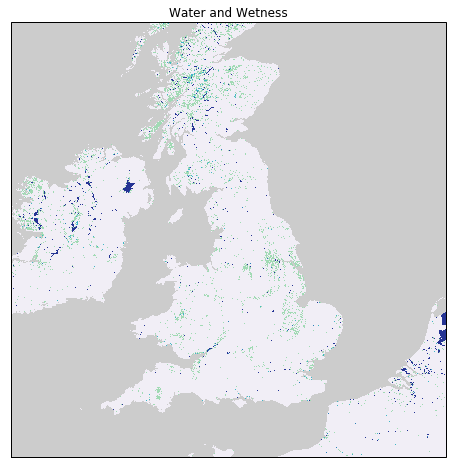

In [11]:
import numpy as np
import cartopy.crs as ccrs
import rasterio
import matplotlib.pyplot as plt
from matplotlib import colors as c
import pyepsg

filename = imagepath
with rasterio.drivers():
    with rasterio.open(filename, 'r') as src:

        # read image into ndarray
        im = src.read(1)
        
        # calculate extent of raster
        xmin = src.transform[0]
        xmax = src.transform[0] + src.transform[1]*src.width
        ymin = src.transform[3] + src.transform[5]*src.height
        ymax = src.transform[3]
        
        # make a copy of the data and change the nodata values to facilitate 
        # plotting
        
        # set the nodata values 
        im[im==254]=5
        im[im==255]=6

        # define cartopy crs for the raster, based on rasterio metadata
        srccrs = src.crs['init'][5:]
        crs = ccrs.epsg(srccrs)

        # create figure
        imgcmap = c.ListedColormap(['#f1eef6',
                                    '#253494',
                                    '#2c7fb8',
                                    '#41b6c4',
                                    '#a1dab4',
                                    '#636363',
                                    '#cccccc',])
      
        subplot_kw = dict(projection=crs)
        fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=subplot_kw)

        plt.title("Water and Wetness")

        # plot raster
        ax.imshow(im, origin='upper', extent=[xmin, xmax, ymin, ymax], 
                  transform=crs, interpolation='nearest', cmap=imgcmap,)
        
        # overlay the local authority boundaries

        # plot coastlines
        #ax.coastlines(resolution='10m', color='red', linewidth=1)
        

        plt.show()

Lets display the local authority boundaries.  These will be used as the regions for which the percentage cover of each class will be calculated.

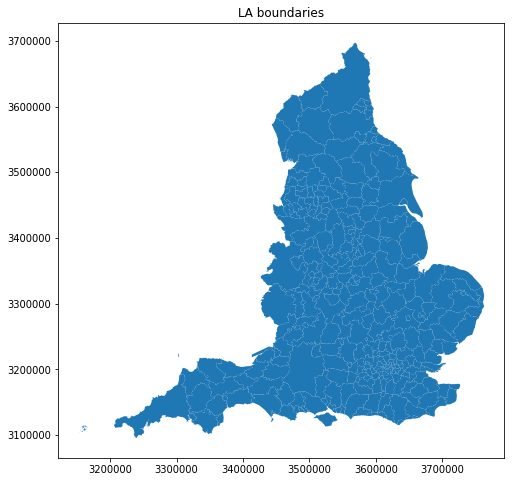

In [4]:
import geopandas as gpd

# read in the shapefile
shape = gpd.read_file(maskpath)

# set up the plot and display
fig, ax = plt.subplots(figsize=(8, 8))
ax = shape.plot(ax=ax)
plt.title("LA boundaries")
plt.show()


A function follows that calculates the percentage cover of each of the classes for each polygon.  Note that it contains code to reclassify the input classes into a smaller number of classes.  We won't use that functionality for this dataset as it has a suitable number of classes.

It would be more useful for a related dataset, the water and wetness probability index.  This has a class for each percentage point and, without reclassifying, would result in over 100 classes (including 0, 254 and 255).

In [5]:
def getpctcover(inraster, maskshp, maskfield, classlist=[]):
    """
    Function to calcluate the percentage cover of each class of a raster 
    covered by the supplied polygon.
    Parameters
    ----------
    inraster : DatasetReader object
        Raster 
    maskshp : Collection feature
        Polygon with attributes to use as the mask
    maskfield : string
        The field name that identifies the polygon
    classlist : list (optional)
        A list of classes to use to reclassify the output
        Where the first element is the top of the first reclassified
        class and the bottom of the next new class, the second element 
        is the top of the second reclassified class.
        The default is an empty list.
    Returns
    -------
    results : list of ordered dictionaries
        Where:
        id = the id of the polygon
        class = the raster class
        percentcover = the percentage of the polygon covered by the polygon
    """

    results = []

    geom = [maskshp['geometry']]
    unit_id = maskshp['properties'][maskfield]

    #print(f"Calculating percent cover for {unit_id}...")

    # mask image to each boundary
    #masked_array, out_transform = mask(src, geom, crop=True)
    masked_array = mask(inraster, geom, crop=True)
    sub_array = masked_array[0]

    # check to see if a reclassification class list has been
    # supplied
    if len(classlist) > 0:
        # group the classes according to values in the list
        for c in range(len(classlist)):
            if c == 0:
                newclass = sub_array <= classlist[c]
            else:
                newclass = ((classlist[c-1] < sub_array) & 
                            (sub_array <= classlist[c]))
            sub_array[newclass] = classlist[c]

    # get the total count of elements in the array to use in the 
    # percentage calculations
    # this excludes 255 (the original no data value) and
    # 256 (the nodata values that result from the mask operation)
    # but retains 254 where, for example, cloud obscured results
    total_count = len(sum(np.where(sub_array <= 254)))

    # get the count of each class
    unique, counts = np.unique(sub_array, return_counts=True)

    # calculate the percentage of each class
    for v in np.asarray((unique, counts)).T:
        category = v[0]
        # exclude the no data values from the results
        if category != 256 and category != 255:
            percent = (v[1]/total_count)*100

            classresults = collections.OrderedDict()
            classresults['id'] = unit_id
            classresults['class'] = category
            classresults['percentcover'] = percent

            results.append(classresults)
            
    return results

Now we'll open the files and carry out the calculations using the above function

In [6]:
%%time
results = []

# open the files
with rasterio.open(imagepath) as src:

    with fiona.open(maskpath, "r") as shapefile:
        for shp in shapefile:
            shpresults = []
            # get percentage cover for each shape
            shpresults = getpctcover(src, shp, maskfield)
            for result in shpresults:
                results.append(result)


Wall time: 6.24 s


We'll convert this list of ordered dictionaries into a dataframe so we can manipulate it and join it onto the local authority boundaries.

In [7]:
import pandas as pd

df = pd.DataFrame(results)

# display the first ten results
df.head(10)

,id,class,percentcover
0,18805,0,96.377856
1,18805,1,0.596831
2,18805,2,0.123482
3,18805,3,0.391027
4,18805,4,2.510805
5,9123,0,98.043387
6,9123,1,0.467355
7,9123,2,0.087193
8,9123,3,0.024414
9,9123,4,1.377651


Rearrange the dataframe so that the id is used as the index and the classes become columns

In [8]:
wetness = df.pivot(index='id', columns='class')['percentcover']
wetness.reset_index(level=0, inplace=True)
wetness.fillna(value=0, inplace=True)

wetness.head(10)

class,id,0,1,2,3,4,254
0,9,99.775772,0.201805,0.005606,0.000000,0.016817,0.0
1,18,99.492424,0.373218,0.014929,0.000000,0.119430,0.0
2,33,99.939216,0.050653,0.000000,0.000000,0.010131,0.0
3,72,99.855908,0.134486,0.009606,0.000000,0.000000,0.0
4,81,99.719823,0.210133,0.023348,0.000000,0.046696,0.0
5,109,99.877539,0.122461,0.000000,0.000000,0.000000,0.0
6,156,99.985605,0.014395,0.000000,0.000000,0.000000,0.0
7,1255,92.606239,0.319332,0.073692,0.171948,6.828789,0.0
8,1303,89.321874,0.177433,0.021070,0.088716,10.390907,0.0
9,1348,82.825230,0.204060,0.056768,0.064440,16.849502,0.0


Join this dataframe onto the local authority boundaries

In [9]:
wetness.rename(columns={'id': 'UNIT_ID',
                          0 : 'Class0',
                          1 : 'Class1',
                          2 : 'Class2',
                          3 : 'Class3',
                          4 : 'Class4',
                        254 : 'Class254'}, inplace=True)

la_wetness = shape.merge(wetness, on='UNIT_ID')
la_wetness.head()


,NAME,AREA_CODE,DESCRIPTIO,FILE_NAME,NUMBER,NUMBER0,POLYGON_ID,UNIT_ID,CODE,HECTARES,...,DESCRIPT0,TYPE_COD0,DESCRIPT1,geometry,Class0,Class1,Class2,Class3,Class4,Class254
0,Salford District (B),MTD,Metropolitan District,SALFORD_DISTRICT_(B),6,44,56575,18805,E08000006,9719.732,...,CIVIL ADMINISTRATION AREA,None,None,"POLYGON ((3497080.004448751 3441040.135290764,...",96.377856,0.596831,0.123482,0.391027,2.510805,0.0
1,Rotherham District (B),MTD,Metropolitan District,ROTHERHAM_DISTRICT_(B),3,106,50362,9123,E08000018,28653.431,...,CIVIL ADMINISTRATION AREA,None,None,"POLYGON ((3577869.395399302 3413457.489282725,...",98.043387,0.467355,0.087193,0.024414,1.377651,0.0
2,Rochdale District (B),MTD,Metropolitan District,ROCHDALE_DISTRICT_(B),4,44,56595,18825,E08000005,15812.803,...,CIVIL ADMINISTRATION AREA,None,None,"POLYGON ((3529204.696776078 3457243.93698071, ...",96.872236,0.985720,0.082143,0.000000,2.059901,0.0
3,Oldham District (B),MTD,Metropolitan District,OLDHAM_DISTRICT_(B),8,48,56458,18690,E08000004,14234.507,...,CIVIL ADMINISTRATION AREA,None,None,"POLYGON ((3530367.215723878 3455639.602156796,...",97.263734,0.652494,0.007016,0.000000,2.076756,0.0
4,Solihull District (B),MTD,Metropolitan District,SOLIHULL_DISTRICT_(B),3,69,40102,9,E08000029,17828.205,...,CIVIL ADMINISTRATION AREA,None,None,"POLYGON ((3519877.33624913 3316004.374645095, ...",99.775772,0.201805,0.005606,0.000000,0.016817,0.0


Display the results in map form using class 4: temporary wetness

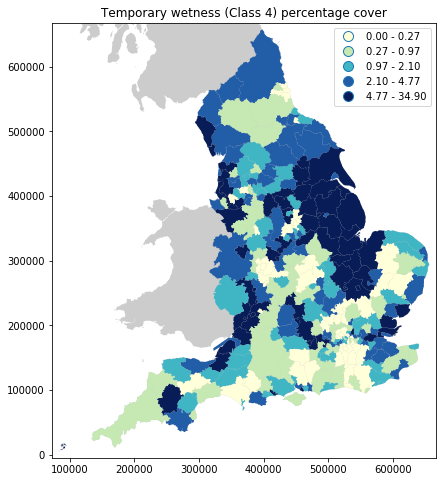

In [10]:
# set up the plot and display
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect('equal')

# reproject the wetness index to National Grid
la_wetness.crs = {'init' :'epsg:3035'}
prjwet = la_wetness.to_crs({'init': 'epsg:27700'})

# set extent
bounds = prjwet.geometry.bounds
margin = 10000
plt.xlim([bounds.minx.min()-margin, bounds.maxx.max()+margin])
plt.ylim([bounds.miny.min()-margin, bounds.maxy.max()+margin]);

# read in the background shapefile
bkgrd = gpd.read_file(backshp)
bgcmap = c.ListedColormap(['#cccccc',])

# plot layers
bkgrd.plot(ax=ax, cmap=bgcmap)
prjwet.plot(ax=ax, column='Class4', legend = True, cmap='YlGnBu', scheme='quantiles')

plt.title("Temporary wetness (Class 4) percentage cover")

plt.show()
